In [1]:
from flakylib import *
import re
import math
import numpy as np
import numba as nb
from numba import prange
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generation of Synthetic Dataset (Overlapping Blobs on Regular Grid)

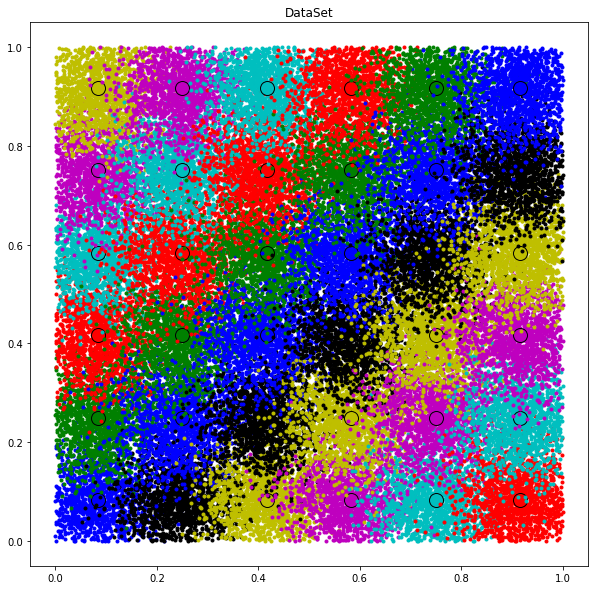

In [18]:
Drawing = True # If n_features > 2 then Drawing = True

grid_size = 6
n_features = 2
n_samples = 60000
standard_deviation = 0.06
n_candidates = 3
nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing


samples, true_sample_membership, true_centroids = generate_blobs_on_grid(n_samples, grid_size, n_features, standard_deviation)

if Drawing:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   

# Generation of Synthetic Dataset (Random Distributed Blobs)

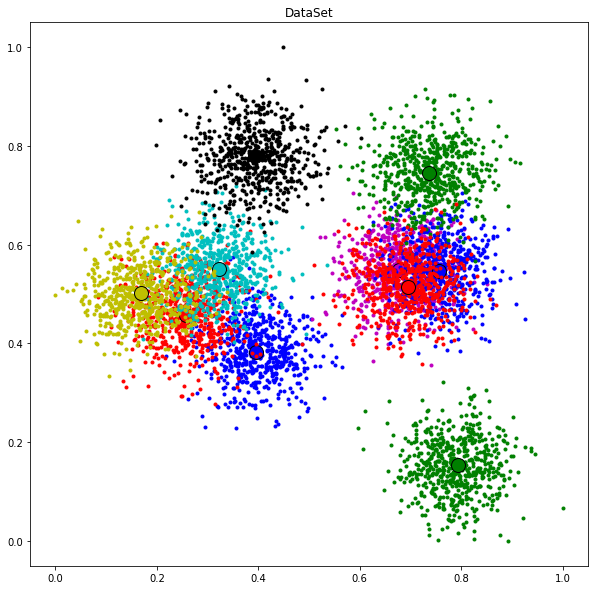

In [3]:
Drawing = True # If n_features > 2 then Drawing = True

grid_size = 6
n_features = 2
n_samples = 6000
standard_deviation = 0.07
n_candidates = 3
nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing
n_cluster = 10

samples, true_centroids, true_sample_membership = generate_dataset1(n_features, n_samples, n_cluster, standard_deviation)


if Drawing:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   



# Generation of Synthetic Dataset (Random Distributed Samples)

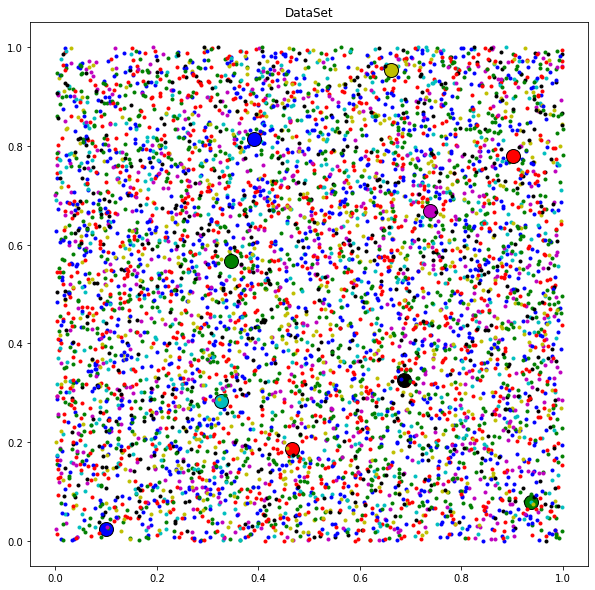

In [4]:
Drawing = True # If n_features > 2 then Drawing = True

n_features = 2
n_samples = 6000
n_clusters = 10
n_candidates = 3
nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

samples = np.random.sample((n_samples,n_features))

true_sample_membership = np.random.randint(n_clusters, size = n_samples)
true_centroids = np.random.sample((n_clusters,n_features))

if Drawing:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
 

# Initialization by True Centroids

In [7]:
%%time

centroids = np.copy(true_centroids)

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 232.83114948784723

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 5.07 ms


# Initialization by Random Centroids

In [8]:
%%time

centroids = np.random.rand(n_clusters, n_features)

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')


Objective 76.2571629827292

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.07 ms


# Initialization by K-Means++

In [9]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
centroids_copy = np.copy(centroids)

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 31.060930980591102

CPU times: user 9.95 s, sys: 0 ns, total: 9.95 s
Wall time: 9.93 s


# K-Means initialized by True Centroids

In [11]:
%%time

centroids = np.copy(true_centroids)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 22.70040340804203
Iterations: 16
Clusters: 36

CPU times: user 8.58 s, sys: 0 ns, total: 8.58 s
Wall time: 8.55 s


# K-Means initialized by K-Means++ with sample_objectives as weights

In [15]:
new_sample_weights = 1-normalization(sample_objectives)
center_inds = k_means_pp(samples, new_sample_weights, n_clusters, n_candidates)
centroids = samples[center_inds]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.652726961415986
Iterations: 76
Clusters: 36



# K-Means initialized by Random Centroids

In [12]:
%%time

centroids = np.random.rand(n_clusters, n_features)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.018262371211794
Iterations: 85
Clusters: 35

CPU times: user 260 ms, sys: 0 ns, total: 260 ms
Wall time: 63.7 ms


# K-Means initialized by K-Means++

In [15]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 236.13495078342314
Iterations: 86
Clusters: 36

CPU times: user 1.9 s, sys: 88 ms, total: 1.98 s
Wall time: 411 ms


# K-Means initialized by K-Means++ (sklearn)

In [14]:
%%time

# MiniBatchKMeans(KMeans) in SKLEARN ????!!!!

km = KMeans(n_clusters=n_clusters, init = 'k-means++', algorithm = 'full', n_init=1, n_jobs=1)
#km = KMeans(n_clusters=n_clusters, init = 'random', n_init=1, n_jobs=1)
km = km.fit(samples)

print('Objective:', -km.score(samples))
print('Iterations:',km.n_iter_)

Objective: 22.657108710149068
Iterations: 41
CPU times: user 48 ms, sys: 72 ms, total: 120 ms
Wall time: 1.12 s


# H-Means (first-improvement strategy) initialized by True Centroids

In [23]:
%%time

centroids = np.copy(true_centroids)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.703786964713515
Iterations: 12
Clusters: 36

CPU times: user 80 ms, sys: 4 ms, total: 84 ms
Wall time: 80.7 ms


# H-Means (first-improvement strategy) initialized by K-Means++

In [25]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.276836147524847
Iterations: 40
Clusters: 36

CPU times: user 336 ms, sys: 0 ns, total: 336 ms
Wall time: 328 ms


# H-Means initialized by Random Membership Distribution

In [27]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

random_membership(n_samples, n_clusters, sample_membership)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.482478914833887
Iterations: 34
Clusters: 36

CPU times: user 244 ms, sys: 4 ms, total: 248 ms
Wall time: 252 ms


# K-H-Means initialized by True Centroids

In [28]:
%%time

centroids = np.copy(true_centroids)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001

objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.701838760714182
Iterations: 36
Clusters: 36

CPU times: user 5.57 s, sys: 24 ms, total: 5.59 s
Wall time: 5.53 s


# K-H-Means initialized by K-Means++

In [29]:
%%time

centroids = np.copy(centroids_copy)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001


objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.269656127000662
Iterations: 97
Clusters: 36

CPU times: user 360 ms, sys: 32 ms, total: 392 ms
Wall time: 217 ms


# Simple Membership Shaking VNS

In [31]:
%%time

max_cpu_time = 10 # seconds
max_iters = 3000 # maximun number of iterations inside VNS

kmax = 3
h_max_iters = 3000
k_max_iters = 3000
h_tol = 0.00000001
k_tol = 0.00000001


#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

#Glogal search

objective, n_iters = Membership_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, h_max_iters, k_tol, h_tol, kmax, max_cpu_time, max_iters, True)

print('')
print('Final objective:', objective)
print('Total number of iterations:', n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.785906491902537
Iterations: 73
Clusters: 36

23.785906491902498 1
23.783326727802333 1
23.78332672780233 1
23.781102708792346 3
23.78110270879234 1
23.781102708792336 3
23.78108101715161 2
23.781081017151607 2
23.78045022322945 3
23.780318151933702 1
23.75028282805752 2
23.750282828057507 1
23.75024477545592 1
23.750244775455915 1
23.75024477545591 2
23.75024477545591

Final objective: 23.75024477545591
Total number of iterations: 675
Clusters: 36

CPU times: user 14.4 s, sys: 972 ms, total: 15.4 s
Wall time: 10.1 s


# Solution Visualization

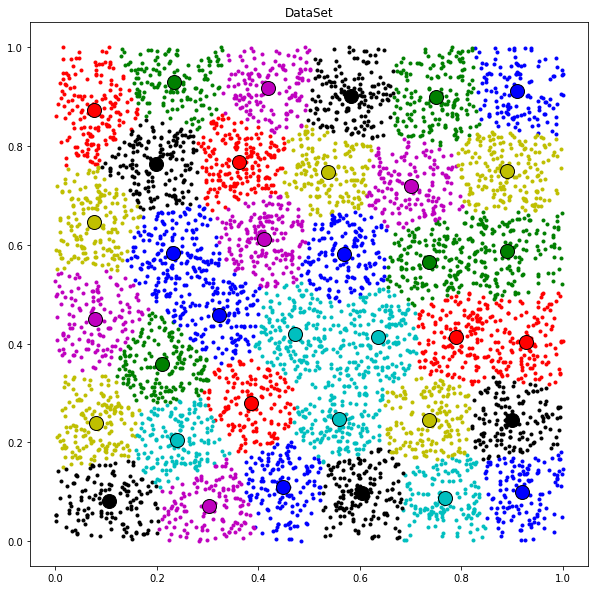

In [33]:
draw_dataset(samples, centroids, sample_membership)

# Local Search by Iteratively New Extra Center Insertion, Searching and Worst Centroid Deletion

In [25]:
%%time

k_max_iters = 600
k_tol=0.000001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, k_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Search

objective, n_iters, n_k_iters = iterative_extra_center_insertion_deletion(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, k_tol, max_iters, tol, max_cpu_time, n_candidates, True)
                                
print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_k_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 240.96585675053802
Iterations: 40
Clusters: 36

239.92265138526668
234.06439461075033
230.2168712930612
230.21306187796122
230.21306187796122

Objective: 230.21306187796122
Global Iterations: 20
Local Iterations: 27
Clusters: 36

CPU times: user 1min 5s, sys: 1.64 s, total: 1min 7s
Wall time: 10.5 s


# Solution Visualization

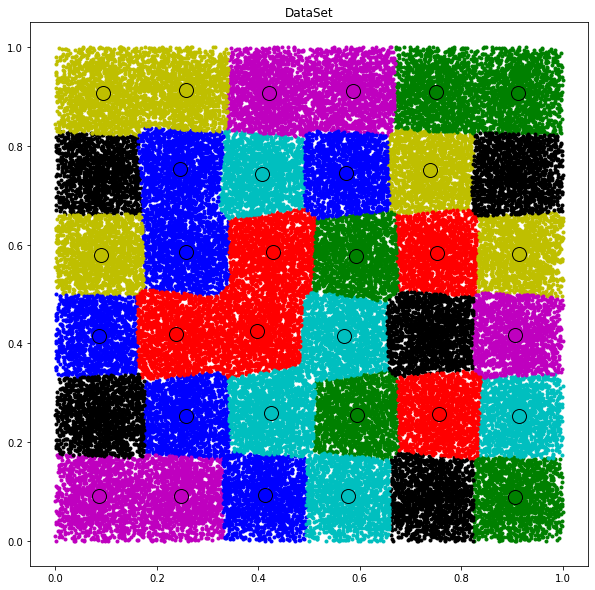

In [21]:
draw_dataset(samples, centroids, sample_membership)

# Simple Center Shaking VNS

In [26]:
%%time

kmax = 5

local_max_iters = 600
local_tol=0.000001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, local_max_iters, local_tol)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Global Search

objective, n_iters, n_local_iters = Center_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, local_max_iters, local_tol, kmax, max_cpu_time, max_iters, n_candidates, True)

print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 230.23552444687982
Iterations: 95
Clusters: 36

230.22210204377424 3
230.2158580864429 1
230.2158580864429

Objective: 230.2158580864429
Global Iterations: 44
Local Iterations: 114
Clusters: 36

CPU times: user 56.5 s, sys: 1.78 s, total: 58.3 s
Wall time: 10.6 s


# Solution Visualization

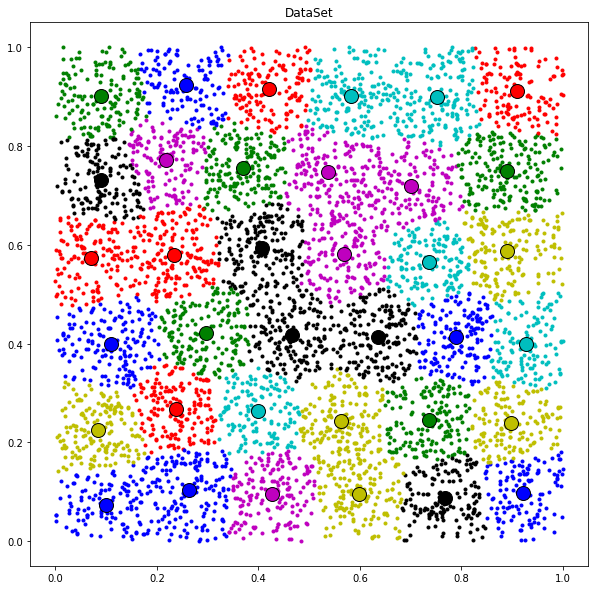

In [39]:
draw_dataset(samples, centroids, sample_membership)

# Sequencing of Different Methods

In [27]:
%%time

printing=True
local_max_iters=300
local_tol=0.00001
n_candidates=3
kmax = 5
max_iters = 3000
max_cpu_time = 3 # seconds


method_sequence = np.array([0, 4, 5, 4, 5, 3])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)
#kmax_sequence = np.full(method_sequence.shape[0],kmax)
kmax_sequence = np.array([5,5,5,5,15,5])

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

objective = method_sequencing(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, np.inf, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, local_max_iters, local_tol, n_candidates, printing)

K-means:
235.171461979455

Center Shaking VNS:
235.14595495863057 1
230.29722587606562 1
230.28631967426438 1
230.28205424196412 2
230.27347207928108 1
230.26835683330523 2
230.24497806792346 2
230.24497806792346

Membership Shaking VNS:
230.23823953687187 1
230.2360873038052 1
230.23460189333733 1
230.2249008262195 1
230.22304567459074 1
230.2217820885514 1
230.2201600225548 1
230.2193001923374 1
230.21880431924873 1
230.2187171928068 2
230.2186728679794 1
230.21866573942643 1
230.21866573942623 1
230.21863535523093 1
230.21862640171608 1
230.2186264017159 1
230.2186264017159

Center Shaking VNS:
230.21764433889288 3
230.21677958136402 1
230.21677958136402

Membership Shaking VNS:
230.21459648687394 1
230.2143727628156 1
230.21422931947518 1
230.21417659043195 1
230.2141411472533 1
230.21413952927327 1
230.21413256068644 1
230.21388702211098 7
230.213726580552 1
230.21372658055176 1
230.21371404371072 2
230.21371404371072

K-H-means:
230.2137063222931

CPU times: user 45.9 s, sys: 1.4

# Solution Visualization

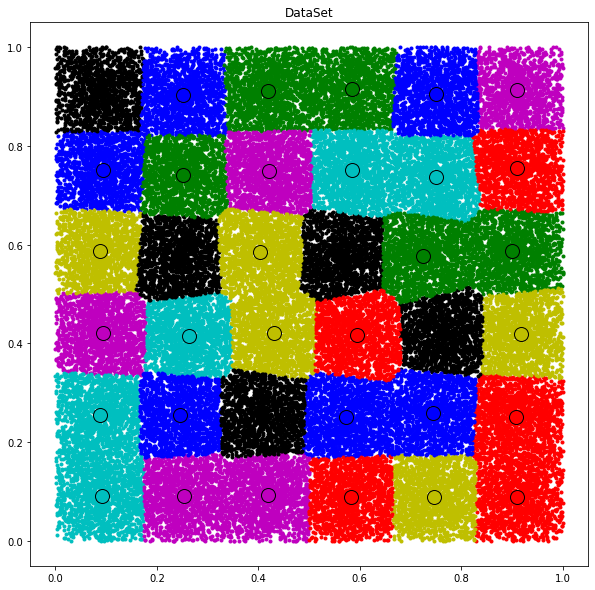

In [10]:
draw_dataset(samples, centroids, sample_membership)

# VNS based Decomposition/Aggregation Minimum Sum-Of-Squares Clustering

In [12]:
%%time

portion_size = 20000
n_portions = 5
init_method = 1
local_max_iters = 3000
local_tol = 0.000000001
max_cpu_time = 3
max_iters = 3000000
n_candidates = 6
aggregation_method = 1
basis_n_init = 3


method_sequence = np.array([0, 4, 5, 4, 5, 3])
kmax_sequence = np.array([0,5,5,5,15,0])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)


objective, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = decomposition_aggregation_mssc(samples, sample_weights, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, n_clusters, portion_size, n_portions, init_method, local_max_iters, local_tol, n_candidates, aggregation_method, basis_n_init)



CPU times: user 3min 25s, sys: 15.3 s, total: 3min 41s
Wall time: 37.3 s


In [13]:
objective

231.00163046893965